In [4]:
import re
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain
from collections import Counter

from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import LabelEncoder

sys.path.append('../src')
from encode import *
from label_candidates_extract import LabelCandidatesExtracter

### Обучающая выборка

Для "обучения" алгоритма TopMine, т.е. для подсчёта частотности чанков на шаге Frequent Phrase Mining, формируем список предложений извлечённых из заголовков и текстов.

In [5]:
articles = pd.read_csv('../data/interim/articles_preproc.csv')

articles.title_preproc = articles.title_preproc.apply(conllu_encoder)
articles.text_preproc = articles.text_preproc.apply(conllu_encoder)

sentences = list(chain(*articles.title_preproc))+list(chain(*articles.text_preproc))

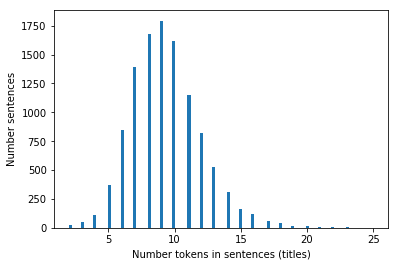

In [6]:
len_titles = articles.title_preproc.apply(lambda x: len(list(chain(*[sent.tokens for sent in x]))))

plt.figure()
plt.hist(len_titles, bins=100)
plt.xlabel('Number tokens in sentences (titles)')
plt.ylabel('Number sentences')
plt.show()

Видим, что заголовки не содердат более 25 слов. Поэтому ограничем длину кандидата в заголовок 50 словами.

In [7]:
lce = LabelCandidatesExtracter(min_count=3, max_len=25).fit(sentences)
lce.dump('../models/label_candidates_extracter')

100%|██████████| 25/25 [00:18<00:00,  7.72it/s]


### Выделение кандидатов в заголовках и текстах статей

Сформируем таблицу candidates.csv кандидатов в заголовки:

* **article_id** - идентификатор новостной статьи
* **part** - часть статьи ('title', 'text')
* **sent_id** - идентификатор предложения
* **sent_n** - количество предложений в тексте
* **sent_len** - количество слов в предложении
* **begin_index** - индекс, с которого начинается фраза в предложении 
* **end_index** - индекс, которым заканчивается фраза в предложении
* **form_id** - идентификатор кандидата (слова в изначальной грамматической форме)
* **lemma_id** - идентификатор кандидата (слова в нормальной грамматической форме)
* **poses** - части речи
* **tags** - морфологические разборы слов
* **head** - синтаксические связи
* **sig** - sig из TopMine

Также будут таблицы candidate_forms.csv и candidate_lemmas.csv, в которых храняться соответсвующие фразы и их идентификаторы.

In [8]:
candidates = []
lce = LabelCandidatesExtracter().load('../models/label_candidates_extracter')

for _, article in tqdm(articles.iterrows()):
    
    for part in ['title', 'text']:
        
        sentences =  article[part+'_preproc']
        sent_n = len(sentences)
        
        for sentence in sentences:
            
            tokens = sentence.tokens
            sent_len = len(tokens)
            
            for begin, end, sig in lce.transform(sentence):
            
                candidate = tokens[begin:end]
                
                #не рассматриваем словосочетания начинающиеся и заканчивающиеся пунктуацией
                if candidate[0].pos == 'PUNCT' or candidate[-1].pos == 'PUNCT':
                    continue
                    
                lemma = ''.join([token.lemma+' '*token.space for token in candidate]).strip()
                
                form = ''.join([token.token+' '*token.space for token in candidate]).strip()
                form = form[0].upper()+form[1:]
                
                poses, tags, heads = zip(*[(token.pos, token.tag, token.head) for token in candidate])
                candidates.append((article.id, part, sentence.id, sent_n, sent_len, 
                                   begin, end, form, lemma, list(poses), list(tags), list(heads), sig))
                
columns = ['article_id', 'part', 'sent_id', 'sent_n', 'sent_len', 
           'begin_index', 'end_index', 'form_id', 'lemma_id', 
           'poses', 'tags', 'heads', 'sig']

candidates = pd.DataFrame(candidates, columns=columns)

#формируем список кандидатов
label_encoder = LabelEncoder().fit(candidates.form_id)
candidates.form_id = label_encoder.transform(candidates.form_id)

candidate_forms = label_encoder.classes_
candidate_forms = pd.DataFrame({'id':range(len(candidate_forms)), 'candidate':candidate_forms})

candidate_forms.to_csv('../data/interim/candidate_forms.csv', index=False)

#формируем список лемм кандидатов
label_encoder = LabelEncoder().fit(candidates.lemma_id)
candidates.lemma_id = label_encoder.transform(candidates.lemma_id)

candidate_lemmas = label_encoder.classes_
candidate_lemmas = pd.DataFrame({'id':range(len(candidate_lemmas)), 'candidate':candidate_lemmas})

candidate_lemmas.to_csv('../data/interim/candidate_lemmas.csv', index=False)

candidates.to_pickle('../data/interim/candidates.pkl')

print(f'Всего в корпусе было выделенно {len(candidates)} фраз')
print(f'Уникальных фраз {len(candidate_forms)}')
print(f'После лемматизации уникальных фраз стало {len(candidate_lemmas)}')

11127it [00:52, 211.87it/s]


Всего в корпусе было выделенно 759854 фраз
Уникальных фраз 181439
После лемматизации уникальных фраз стало 116641


### Сокращение числа кандидатов в заголовки

In [37]:
#определение корни поддерева
def get_root(begin_index, end_index, heads):
    for index, head in enumerate(heads):
        if not begin_index <= head < end_index:
            return index

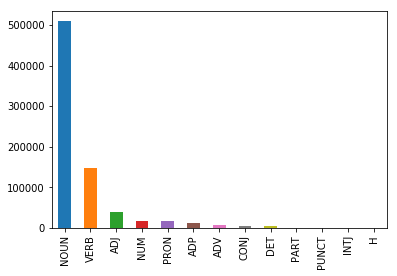

In [38]:
main_poses = candidates.apply(lambda x: x.poses[get_root(x.begin_index, x.end_index, x.heads)], axis=1)
main_poses.value_counts().plot.bar()

Оставим только фразы, где корнем в синтаксическом дереве является либо сущиствительное (NOUN), либо глагол (VERB)

In [39]:
candidates_noun = candidates[main_poses == 'NOUN']
candidates_verb = candidates[main_poses == 'VERB']

print('NOUN')
print(f'\tВсего в корпусе было выделенно {len(candidates_noun)} фраз')
print(f'\tУникальных фраз {len(candidates_noun.form_id.unique())}')
print(f'\tПосле лемматизации уникальных фраз стало {len(candidates_noun.lemma_id.unique())}')

print('VERB')
print(f'\tВсего в корпусе было выделенно {len(candidates_verb)} фраз')
print(f'\tУникальных фраз {len(candidates_verb.form_id.unique())}')
print(f'\tПосле лемматизации уникальных фраз стало {len(candidates_verb.lemma_id.unique())}')

candidates_noun.to_pickle('../data/interim/candidates_noun.pkl')
candidates_verb.to_pickle('../data/interim/candidates_verb.pkl')

NOUN
	Всего в корпусе было выделенно 510237 фраз
	Уникальных фраз 112555
	После лемматизации уникальных фраз стало 71567
VERB
	Всего в корпусе было выделенно 147106 фраз
	Уникальных фраз 50545
	После лемматизации уникальных фраз стало 32986


Среди именованных груп оставим только фразы, где главное слово стоит в именительном падеже

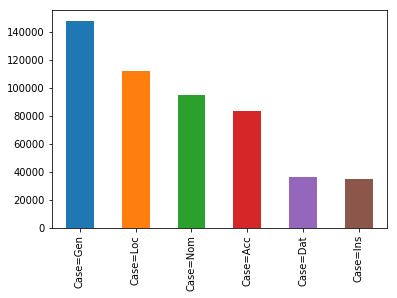

In [40]:
candidates_noun_main_case = candidates_noun.apply(lambda x: x.tags[get_root(x.begin_index, x.end_index, x.heads)], axis=1)
candidates_noun_main_case = candidates_noun_main_case.apply(lambda x: x.split('|')[0])
candidates_noun_main_case.value_counts().plot.bar()

In [42]:
candidates_noun_nom = candidates_noun[candidates_noun_main_case == 'Case=Nom']

print('NOUN Case=Nom')
print(f'\tВсего в корпусе было выделенно {len(candidates_noun_nom)} фраз')
print(f'\tУникальных фраз {len(candidates_noun_nom.form_id.unique())}')
print(f'\tПосле лемматизации уникальных фраз стало {len(candidates_noun_nom.lemma_id.unique())}')

candidates_noun_nom.to_pickle('../data/interim/candidates_noun_nom.pkl')

NOUN Case=Nom
	Всего в корпусе было выделенно 94686 фраз
	Уникальных фраз 27016
	После лемматизации уникальных фраз стало 24594


In [81]:
groups_by_lemma_id_len = candidates_verb.groupby('lemma_id').apply(lambda x: x.form_id.unique()).apply(len)

mult_lemma_id = groups_by_lemma_id_len[groups_by_lemma_id_len > 1].index
sing_lemma_id = groups_by_lemma_id_len[groups_by_lemma_id_len == 1].index

candidates_verb_mult = candidates_verb[candidates_verb.lemma_id.isin(mult_lemma_id)]
candidates_verb_sing = candidates_verb[candidates_verb.lemma_id.isin(sing_lemma_id)]

print('VERB mult')
print(f'\tВсего в корпусе было выделенно {len(candidates_verb_mult)} фраз')
print(f'\tУникальных фраз {len(candidates_verb_mult.form_id.unique())}')
print(f'\tПосле лемматизации уникальных фраз стало {len(candidates_verb_mult.lemma_id.unique())}')

print('VERB sing')
print(f'\tВсего в корпусе было выделенно {len(candidates_verb_sing)} фраз')
print(f'\tУникальных фраз {len(candidates_verb_sing.form_id.unique())}')
print(f'\tПосле лемматизации уникальных фраз стало {len(candidates_verb_sing.lemma_id.unique())}')

candidates_verb_mult.to_pickle('../data/interim/candidates_verb_mult.pkl')
candidates_verb_sing.to_pickle('../data/interim/candidates_verb_sing.pkl')

VERB mult
	Всего в корпусе было выделенно 81383 фраз
	Уникальных фраз 27956
	После лемматизации уникальных фраз стало 10390
VERB sing
	Всего в корпусе было выделенно 65723 фраз
	Уникальных фраз 22593
	После лемматизации уникальных фраз стало 22596


### Формирование данных для Яндекс.Толока (формат *.tsv)

In [71]:
candidates_noun_nom_toloka = candidate_forms[candidate_forms.id.isin(candidates_noun_nom.form_id.unique())]

pull_n = 3
pull_size = len(candidates_noun_nom_toloka)//pull_n+1

for index in range(pull_n):
    
    pull = candidates_noun_nom_toloka[index*pull_size:(index+1)*pull_size]
    pull = '\n'.join(pull.candidate.apply(lambda x: x+'\t\t'))

    with open(f'../data/interim/candidates_noun_nom_toloka_{index}.tsv', 'w', encoding='utf-8') as fl:
            fl.write('INPUT:text\tGOLDEN:result\tHINT:text\n'+pull)

In [82]:
candidates_verb_sing_toloka = candidate_forms[candidate_forms.id.isin(candidates_verb_sing.form_id.unique())]

pull_n = 3
pull_size = len(candidates_verb_sing_toloka)//pull_n+1

for index in range(pull_n):
    
    pull = candidates_verb_sing_toloka[index*pull_size:(index+1)*pull_size]
    pull = '\n'.join(pull.candidate.apply(lambda x: x+'\t\t'))

    with open(f'../data/interim/candidates_verb_sing_toloka_{index}.tsv', 'w', encoding='utf-8') as fl:
            fl.write('INPUT:text\tGOLDEN:result\tHINT:text\n'+pull)

In [88]:
candidates_verb_mult_toloka = []

for _, group in candidates_verb_mult.groupby('lemma_id'):
    group = candidate_forms[candidate_forms.id.isin(group.form_id.unique())]
    count = len(group)
    
    group = '\n'.join(group.candidate.apply(lambda x: x+'\t\t'))
    candidates_verb_mult_toloka.append((count, group))

candidates_verb_mult_toloka = sorted(candidates_verb_mult_toloka, key=lambda x: x[0], reverse=True)
_, candidates_verb_mult_toloka = zip(*candidates_verb_mult_toloka)

pull_n = 3
pull_size = len(candidates_verb_mult_toloka)//pull_n+1

for index in range(pull_n):
    
    pull = '\n\n'.join(candidates_verb_mult_toloka[index*pull_size:(index+1)*pull_size])
    with open(f'../data/interim/candidates_verb_mult_toloka_{index}.tsv', 'w', encoding='utf-8') as fl:
            fl.write('INPUT:text\tGOLDEN:result\tHINT:text\n'+pull)